# **Title**: Transparent Medical AI

- **Data Pre-Processing**: *Shyamkumar Moradiya*
- **CNN Model and Training**: *Harshita Ambati*
- **LLM Integration and Training**: *Meetkumar Patel*
- **Data Analysis and Evaluation**: *Jenny Varghese*

In [8]:
# imports
from pathlib import Path
import os, random, hashlib, gc
import numpy as np
import pandas as pd
from PIL import Image
import kagglehub

# Reproducibility
SEED = 42
random.seed(SEED) 
np.random.seed(SEED)

# dataset path
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
DATA_ROOT = Path(path)
TRAIN_DIR = DATA_ROOT / "Training"
TEST_DIR  = DATA_ROOT / "Testing"

# Artifacts
ARTIFACTS_DIR = DATA_ROOT / "_artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("Train:", TRAIN_DIR.resolve())
print("Test :", TEST_DIR.resolve())
print("Artifacts ->", ARTIFACTS_DIR.resolve())


Train: /Users/hambati/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training
Test : /Users/hambati/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing
Artifacts -> /Users/hambati/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/_artifacts


In [9]:
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

# Helpers
def is_image_file(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def md5_of_file(p: Path, chunk=8192):
    h = hashlib.md5()
    with open(p, "rb") as f:
        for b in iter(lambda: f.read(chunk), b""):
            h.update(b)
    return h.hexdigest()

def scan_split(split_dir: Path, split_name: str) -> pd.DataFrame:
    rows = []
    for cls_dir in sorted(p for p in split_dir.iterdir() if p.is_dir()):
        label = cls_dir.name
        for p in cls_dir.rglob("*"):
            if p.is_file() and is_image_file(p):
                # Read image metadata (safe)
                try:
                    with Image.open(p) as im:
                        w, h = im.size; mode = im.mode
                except Exception:
                    w, h, mode = None, None, "CORRUPT"
                rows.append({
                    "split": split_name,
                    "path": str(p),
                    "label": label,
                    "width": w, "height": h, "mode": mode,
                    "md5": md5_of_file(p) if w is not None else None
                })
    return pd.DataFrame(rows)


In [10]:
# Scan dataset → DataFrames & save raw metadata
train_df = scan_split(TRAIN_DIR, "train")
test_df  = scan_split(TEST_DIR,  "test")
meta = pd.concat([train_df, test_df], ignore_index=True)

# Save raw metadata
meta.to_csv(ARTIFACTS_DIR / "metadata_raw.csv", index=False)

print("Train images:", len(train_df), " | Test images:", len(test_df))
display(train_df.head())


Train images: 5712  | Test images: 1311


,split,path,label,width,height,mode,md5
0,train,/Users/hambati/.cache/kagglehub/datasets/masou...,glioma,512,512,L,8788e912668ea5bf3ee090780479190c
1,train,/Users/hambati/.cache/kagglehub/datasets/masou...,glioma,512,512,L,bbc661b6d3d07719e545f06a6566ad30
2,train,/Users/hambati/.cache/kagglehub/datasets/masou...,glioma,512,512,L,30ad59af6b969316223579fc99e5571a
3,train,/Users/hambati/.cache/kagglehub/datasets/masou...,glioma,512,512,L,95f63d594138fa63f35ae8e32b049b53
4,train,/Users/hambati/.cache/kagglehub/datasets/masou...,glioma,512,512,L,711a5404bf73eab70fcd2e7f91be86c4


In [11]:
# Quick audit & duplicates
print("By split:\n", meta["split"].value_counts(), "\n")
print("By label (train):\n", train_df["label"].value_counts(), "\n")
print("Image modes (train):\n", train_df["mode"].value_counts(dropna=False), "\n")

dups = train_df.groupby("md5").size().sort_values(ascending=False)
print("Potential duplicates (md5 -> count, top 10):")
print(dups[dups > 1].head(10))


By split:
 split
train    5712
test     1311
Name: count, dtype: int64 

By label (train):
 label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64 

Image modes (train):
 mode
RGB     3236
L       2472
RGBA       3
P          1
Name: count, dtype: int64 

Potential duplicates (md5 -> count, top 10):
md5
79ee916b7b7037c4e54832658aa2848a    5
e0b9f49e9c57547db3d4490d1d96642a    5
24e83deaaae9ab0f15565690e474f5fc    5
5562eae4e5ebc10b36e46caeb073fbc5    4
1829d716613d6d3022da2f82368071ae    4
b3985de17782311036e2c40e43eba428    4
7108f7b2a94c8401f13dae47f666b4e1    4
93d4bba38c027c84aee1f2a001e685a4    3
9eb9f2c929d940f7333441cf7301f205    3
4ceee6f7d03d8681912af6196397b40f    3
dtype: int64


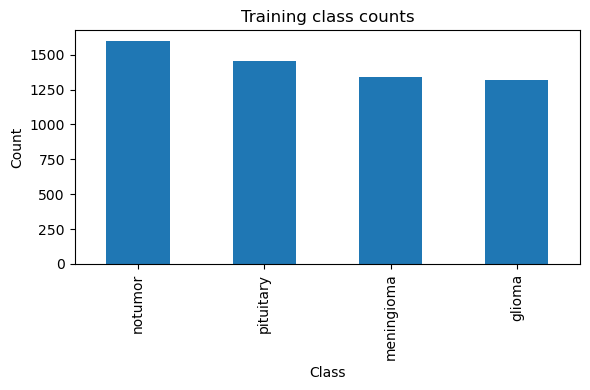

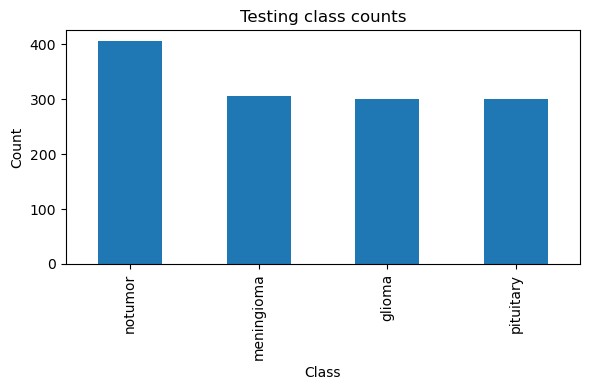

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Safer plotting for large data
matplotlib.rcParams['agg.path.chunksize'] = 100000
plt.close('all'); gc.collect()

# Filter out corrupts & invalid sizes for visualization
viz_train = train_df[(train_df['mode'] != 'CORRUPT') & (train_df['width']>0) & (train_df['height']>0)].copy()
viz_test  = test_df[(test_df['mode'] != 'CORRUPT') & (test_df['width']>0) & (test_df['height']>0)].copy()

def bar_chart_counts(df, title, outpath: Path):
    plt.close('all'); gc.collect()
    counts = df["label"].value_counts().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    counts.plot(kind="bar")
    plt.title(title); plt.xlabel("Class"); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show(); plt.close()

bar_chart_counts(viz_train, "Training class counts", ARTIFACTS_DIR/"class_counts_train.png")
bar_chart_counts(viz_test,  "Testing class counts",  ARTIFACTS_DIR/"class_counts_test.png")


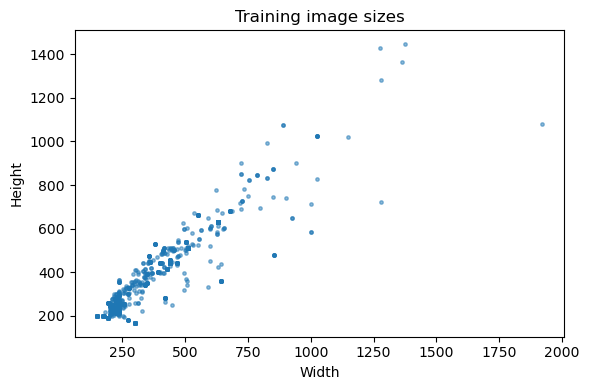

In [13]:
#Image size scatter
sizes = viz_train[['width','height']].dropna().astype('float32')
MAX_POINTS = 50000
if len(sizes) > MAX_POINTS:
    sizes = sizes.sample(n=MAX_POINTS, random_state=SEED)

try:
    plt.figure(figsize=(6,4))
    plt.scatter(sizes['width'].to_numpy(), sizes['height'].to_numpy(), s=6, alpha=0.5)
    plt.title("Training image sizes")
    plt.xlabel("Width"); plt.ylabel("Height")
    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR/"train_sizes_scatter.png", dpi=150)
    plt.show(); plt.close()
except RuntimeError:
    plt.figure(figsize=(6,4))
    plt.hexbin(sizes['width'].to_numpy(), sizes['height'].to_numpy(), gridsize=40)
    plt.title("Training image sizes (hexbin)")
    plt.xlabel("Width"); plt.ylabel("Height")
    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR/"train_sizes_hexbin.png", dpi=150)
    plt.show(); plt.close()


In [15]:
from sklearn.model_selection import train_test_split

# Keep only clean rows for splitting
clean_train = train_df[(train_df["mode"] != "CORRUPT")].copy()

# Stratified by label
idx_all = np.arange(len(clean_train))
tr_idx, va_idx = train_test_split(
    idx_all, test_size=0.2, random_state=SEED, stratify=clean_train["label"]
)

clean_train.loc[tr_idx, "subset"] = "train"
clean_train.loc[va_idx, "subset"] = "val"

# Merge subset back
meta = meta.merge(clean_train[["path","subset"]], on="path", how="left")

# Save bootstraps
meta.to_csv(ARTIFACTS_DIR / "metadata_with_split.csv", index=False)

print(meta["subset"].value_counts(dropna=False))
display(meta.head())


subset
train    4569
NaN      1311
val      1143
Name: count, dtype: int64


,split,path,label,width,height,mode,md5,subset
0,train,/Users/hambati/.cache/kagglehub/datasets/masou...,glioma,512,512,L,8788e912668ea5bf3ee090780479190c,train
1,train,/Users/hambati/.cache/kagglehub/datasets/masou...,glioma,512,512,L,bbc661b6d3d07719e545f06a6566ad30,val
2,train,/Users/hambati/.cache/kagglehub/datasets/masou...,glioma,512,512,L,30ad59af6b969316223579fc99e5571a,train
3,train,/Users/hambati/.cache/kagglehub/datasets/masou...,glioma,512,512,L,95f63d594138fa63f35ae8e32b049b53,train
4,train,/Users/hambati/.cache/kagglehub/datasets/masou...,glioma,512,512,L,711a5404bf73eab70fcd2e7f91be86c4,train


In [16]:
# Compute mean/std on training subset
def load_image_as_rgb(path, target_size=(224,224)):
    im = Image.open(path).convert("RGB")
    im = im.resize(target_size, Image.BILINEAR)
    return np.asarray(im, dtype=np.float32) / 255.0

subset_paths = meta[(meta["subset"]=="train") & (meta["mode"]!="CORRUPT")]["path"].tolist()
sample_paths = subset_paths if len(subset_paths) <= 2000 else random.sample(subset_paths, 2000)

acc = []
for p in sample_paths:
    try:
        rgb = load_image_as_rgb(p)
        acc.append(rgb.reshape(-1,3))
    except Exception:
        pass

if len(acc) == 0:
    raise RuntimeError("No valid images found to compute mean/std. Check training subset.")

acc = np.concatenate(acc, axis=0)
mean = acc.mean(axis=0)   # R,G,B
std  = acc.std(axis=0) + 1e-6

print("Train mean:", mean)
print("Train std :", std)

np.save(ARTIFACTS_DIR/"train_mean.npy", mean)
np.save(ARTIFACTS_DIR/"train_std.npy", std)


Train mean: [0.12415496 0.12415188 0.12417512]
Train std : [0.18026076 0.18025948 0.18029945]


In [17]:
# PyTorch Dataset & DataLoaders
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils as vutils
from collections import Counter

TARGET_SIZE   = 224
BATCH_SIZE    = 32
NUM_WORKERS   = 0    
use_pin       = torch.cuda.is_available()

class ImageClsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, subset: str, target=224, mean=None, std=None, augment=False):
        if "subset" in df.columns:
            self.df = df[df["subset"]==subset].reset_index(drop=True)
        else:
            self.df = df[df["split"]==subset].reset_index(drop=True)
        # keep only clean rows
        self.df = self.df[self.df["mode"]!="CORRUPT"].reset_index(drop=True)

        self.labels = sorted(self.df["label"].unique().tolist())
        self.cls2idx = {c:i for i,c in enumerate(self.labels)}
        self.idx2cls = {i:c for c,i in self.cls2idx.items()}

        self.mean = mean if mean is not None else np.array([0.485,0.456,0.406])
        self.std  = std  if std  is not None else np.array([0.229,0.224,0.225])

        tfs = []
        if augment:
            tfs += [
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomRotation(10),
                transforms.ColorJitter(0.1,0.1)
            ]
        tfs += [
            transforms.Resize((target,target)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean.tolist(), self.std.tolist())
        ]
        self.tf = transforms.Compose(tfs)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im = Image.open(row["path"]).convert("RGB")
        x = self.tf(im)
        y = self.cls2idx[row["label"]]
        return x, y

# Load normalization stats
mean_npy, std_npy = ARTIFACTS_DIR/"train_mean.npy", ARTIFACTS_DIR/"train_std.npy"
mean = np.load(mean_npy) if mean_npy.exists() else None
std  = np.load(std_npy)  if std_npy.exists()  else None

train_ds = ImageClsDataset(meta, "train", target=TARGET_SIZE, mean=mean, std=std, augment=True)
val_ds   = ImageClsDataset(meta, "val",   target=TARGET_SIZE, mean=mean, std=std, augment=False)

# Build test view
test_df_ = meta[meta["split"]=="test"].copy(); test_df_["subset"]="test"
test_ds  = ImageClsDataset(test_df_, "test", target=TARGET_SIZE, mean=mean, std=std, augment=False)

# Class weights & sampler
labels = [y for _,y in (train_ds[i] for i in range(len(train_ds)))]
cnt = Counter(labels); total = sum(cnt.values())
class_weight = {c: total/(len(cnt)*n) for c,n in cnt.items()}
weights = torch.DoubleTensor([class_weight[y] for y in labels])
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=use_pin, persistent_workers=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=use_pin, persistent_workers=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=use_pin, persistent_workers=False)

print("Sizes ->", len(train_ds), len(val_ds), len(test_ds))
print("Classes:", train_ds.cls2idx)


Sizes -> 4569 1143 1311
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [18]:
# PyTorch Dataset & DataLoaders
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils as vutils
from collections import Counter

TARGET_SIZE   = 224
BATCH_SIZE    = 32
NUM_WORKERS   = 0    
use_pin       = torch.cuda.is_available()

class ImageClsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, subset: str, target=224, mean=None, std=None, augment=False):
        if "subset" in df.columns:
            self.df = df[df["subset"]==subset].reset_index(drop=True)
        else:
            self.df = df[df["split"]==subset].reset_index(drop=True)
        # keep only clean rows
        self.df = self.df[self.df["mode"]!="CORRUPT"].reset_index(drop=True)

        self.labels = sorted(self.df["label"].unique().tolist())
        self.cls2idx = {c:i for i,c in enumerate(self.labels)}
        self.idx2cls = {i:c for c,i in self.cls2idx.items()}

        self.mean = mean if mean is not None else np.array([0.485,0.456,0.406])
        self.std  = std  if std  is not None else np.array([0.229,0.224,0.225])

        tfs = []
        if augment:
            tfs += [
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomRotation(10),
                transforms.ColorJitter(0.1,0.1)
            ]
        tfs += [
            transforms.Resize((target,target)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean.tolist(), self.std.tolist())
        ]
        self.tf = transforms.Compose(tfs)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im = Image.open(row["path"]).convert("RGB")
        x = self.tf(im)
        y = self.cls2idx[row["label"]]
        return x, y

# Load normalization stats
mean_npy, std_npy = ARTIFACTS_DIR/"train_mean.npy", ARTIFACTS_DIR/"train_std.npy"
mean = np.load(mean_npy) if mean_npy.exists() else None
std  = np.load(std_npy)  if std_npy.exists()  else None

train_ds = ImageClsDataset(meta, "train", target=TARGET_SIZE, mean=mean, std=std, augment=True)
val_ds   = ImageClsDataset(meta, "val",   target=TARGET_SIZE, mean=mean, std=std, augment=False)

# Build test view
test_df_ = meta[meta["split"]=="test"].copy(); test_df_["subset"]="test"
test_ds  = ImageClsDataset(test_df_, "test", target=TARGET_SIZE, mean=mean, std=std, augment=False)

# Class weights & sampler
labels = [y for _,y in (train_ds[i] for i in range(len(train_ds)))]
cnt = Counter(labels); total = sum(cnt.values())
class_weight = {c: total/(len(cnt)*n) for c,n in cnt.items()}
weights = torch.DoubleTensor([class_weight[y] for y in labels])
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=use_pin, persistent_workers=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=use_pin, persistent_workers=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=use_pin, persistent_workers=False)

print("Sizes ->", len(train_ds), len(val_ds), len(test_ds))
print("Classes:", train_ds.cls2idx)


Sizes -> 4569 1143 1311
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


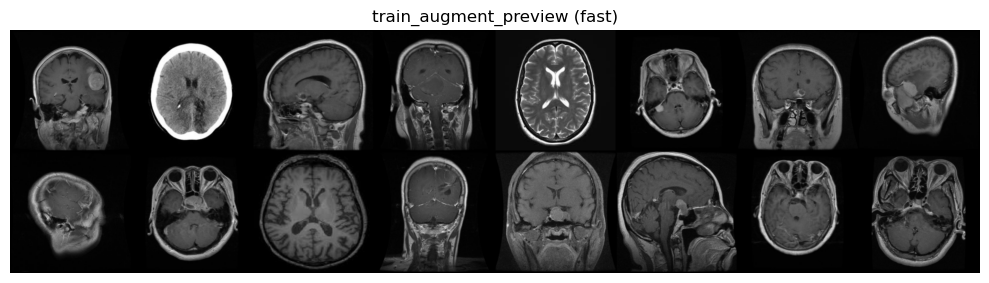

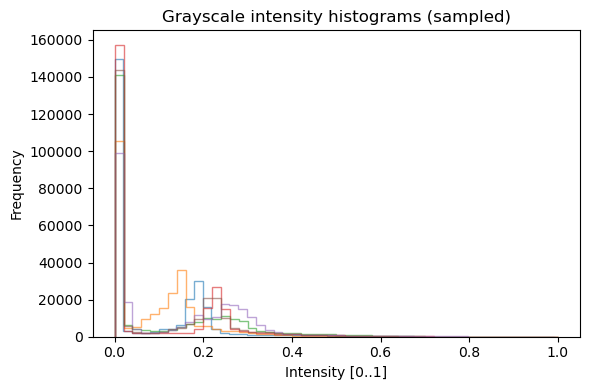

In [ ]:
import matplotlib.pyplot as plt

# Fast montage without DataLoader
subset_paths_for_preview = meta[(meta["subset"]=="train") & (meta["mode"]!="CORRUPT")]["path"].tolist()
sample_paths = random.sample(subset_paths_for_preview, min(16, len(subset_paths_for_preview)))

tf_vis = transforms.Compose([transforms.Resize((TARGET_SIZE,TARGET_SIZE)), transforms.ToTensor()])

imgs = []
for p in sample_paths:
    try:
        im = Image.open(p).convert("RGB")
        imgs.append(tf_vis(im))
    except Exception:
        pass

if len(imgs) == 0:
    raise RuntimeError("No images available for preview montage.")

grid = vutils.make_grid(torch.stack(imgs), nrow=8, normalize=True)
plt.figure(figsize=(10,4))
plt.imshow(grid.permute(1,2,0).cpu().numpy())
plt.axis("off"); plt.title("train_augment_preview (fast)")
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR/"montage_train_fast.png", dpi=150)
plt.show(); plt.close()

# Histograms
subset_paths_for_hist = subset_paths_for_preview[:200]  # limit pool for speed
plt.figure(figsize=(6,4))
for p in random.sample(subset_paths_for_hist, min(6, len(subset_paths_for_hist))):
    arr = np.asarray(Image.open(p).convert("L"), dtype=np.float32)/255.0
    plt.hist(arr.flatten(), bins=50, histtype="step", alpha=0.6)
plt.title("Grayscale intensity histograms (sampled)")
plt.xlabel("Intensity [0..1]"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR/"intensity_histograms.png", dpi=150)
plt.show(); plt.close()


In [19]:
# cache resized 224×224 images
CACHE_DIR = DATA_ROOT / "_cache_224"
CACHE_DIR.mkdir(exist_ok=True)

def cache_split(df, subset, size=(224,224)):
    outdir = CACHE_DIR / subset
    for cls in sorted(df["label"].dropna().unique()):
        (outdir/cls).mkdir(parents=True, exist_ok=True)

    rows = df[(df["subset"]==subset) if "subset" in df.columns else (df["split"]==subset)]
    for _, r in rows.iterrows():
        try:
            im = Image.open(r["path"]).convert("RGB").resize(size, Image.BILINEAR)
            out = outdir / r["label"] / Path(r["path"]).name
            im.save(out)
        except Exception:
            pass

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [21]:
# ============================================================
#                   CNN MODEL
# ============================================================

class MRICNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            # 224 → 112
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # 112 → 56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # 56 → 28
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # 28 → 14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # 14 → 7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1,1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Create model
num_classes = len(train_ds.labels)
model = MRICNN(num_classes).to(DEVICE)
print(model)


MRICNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

In [22]:
# ============================================================
#               LOSS, OPTIMIZER, SCHEDULER
# ============================================================

criterion = nn.CrossEntropyLoss()  # or weighted if imbalanced
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scaler = GradScaler()

/var/folders/q2/tbstrkvn3rd8snkn3llbvkt00000gn/T/ipykernel_14237/1186662997.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/anaconda3/envs/myenvcnn/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [23]:
# ============================================================
#                   TRAINING LOOP
# ============================================================

def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()

        with autocast():
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return running_loss / total, correct / total


def validate(model, loader):
    model.eval()
    total = 0
    correct = 0
    running_loss = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            with autocast():
                logits = model(x)
                loss = criterion(logits, y)
            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += x.size(0)

    return running_loss / total, correct / total



In [24]:
# ============================================================
#                   TRAINING DRIVER
# ============================================================

EPOCHS = 20
best_acc = 0

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), ARTIFACTS_DIR / "best_custom_cnn.pt")
        print("Saved best model!")

print("Training complete.")


Train:   0%|          | 0/143 [00:00<?, ?it/s]/var/folders/q2/tbstrkvn3rd8snkn3llbvkt00000gn/T/ipykernel_14237/2133235150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/myenvcnn/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/q2/tbstrkvn3rd8snkn3llbvkt00000gn/T/ipykernel_14237/2133235150.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | Train Loss: 0.7220, Acc: 0.7229 | Val Loss: 0.7051, Acc: 0.6684
Saved best model!


Epoch 02 | Train Loss: 0.5091, Acc: 0.7995 | Val Loss: 0.7043, Acc: 0.7209
Saved best model!


Epoch 03 | Train Loss: 0.4454, Acc: 0.8363 | Val Loss: 1.1698, Acc: 0.5836


Epoch 04 | Train Loss: 0.3738, Acc: 0.8634 | Val Loss: 0.6600, Acc: 0.7813
Saved best model!


Epoch 05 | Train Loss: 0.3489, Acc: 0.8759 | Val Loss: 0.4005, Acc: 0.8390
Saved best model!


Epoch 06 | Train Loss: 0.3170, Acc: 0.8864 | Val Loss: 0.4149, Acc: 0.8539
Saved best model!


Epoch 07 | Train Loss: 0.3233, Acc: 0.8827 | Val Loss: 0.9633, Acc: 0.6859


Epoch 08 | Train Loss: 0.3044, Acc: 0.8899 | Val Loss: 0.7510, Acc: 0.7200


Epoch 09 | Train Loss: 0.2625, Acc: 0.9022 | Val Loss: 0.3161, Acc: 0.8854
Saved best model!


Epoch 10 | Train Loss: 0.2552, Acc: 0.9083 | Val Loss: 0.5707, Acc: 0.8014


Epoch 11 | Train Loss: 0.2248, Acc: 0.9232 | Val Loss: 0.2599, Acc: 0.9064
Saved best model!


Epoch 12 | Train Loss: 0.2272, Acc: 0.9206 | Val Loss: 0.2244, Acc: 0.9221
Saved best model!


Epoch 13 | Train Loss: 0.2040, Acc: 0.9276 | Val Loss: 0.2509, Acc: 0.8950


Epoch 14 | Train Loss: 0.1834, Acc: 0.9326 | Val Loss: 0.3195, Acc: 0.8889


Epoch 15 | Train Loss: 0.1913, Acc: 0.9306 | Val Loss: 2.0015, Acc: 0.5451


Epoch 16 | Train Loss: 0.1543, Acc: 0.9429 | Val Loss: 0.2525, Acc: 0.8933


Epoch 17 | Train Loss: 0.1664, Acc: 0.9405 | Val Loss: 0.9759, Acc: 0.7122


Epoch 18 | Train Loss: 0.1502, Acc: 0.9459 | Val Loss: 0.2336, Acc: 0.9160


Epoch 19 | Train Loss: 0.1416, Acc: 0.9481 | Val Loss: 0.1843, Acc: 0.9370
Saved best model!


Epoch 20 | Train Loss: 0.1426, Acc: 0.9510 | Val Loss: 0.7883, Acc: 0.7472
Training complete.


In [25]:
# ============================================================
#                   TEST EVALUATION
# ============================================================

model.load_state_dict(torch.load(ARTIFACTS_DIR / "best_custom_cnn.pt"))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=train_ds.labels))

print("\nConfusion Matrix:")
print(confusion_matrix(all_targets, all_preds))

/var/folders/q2/tbstrkvn3rd8snkn3llbvkt00000gn/T/ipykernel_14237/3599749346.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ARTIFACTS_DI


Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.83      0.90       300
  meningioma       0.83      0.84      0.84       306
     notumor       0.94      0.99      0.97       405
   pituitary       0.91      1.00      0.95       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311


Confusion Matrix:
[[248  45   0   7]
 [  1 258  24  23]
 [  0   5 400   0]
 [  0   1   0 299]]


In [ ]:
import json
from torch.nn.functional import softmax

# Store results for each test image
json_results = []

# Make sure model is in eval mode
model.eval()

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(DEVICE)
        logits = model(x)
        probs = softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(1).cpu().numpy()

        for j in range(x.size(0)):
            img_idx = i * BATCH_SIZE + j
            json_results.append({
                "image_index": int(img_idx),
                "true_label": int(y[j].item()),
                "predicted_class": train_ds.idx2cls[preds[j]],
                "confidence": float(probs[j].max()),
                "class_probabilities": {train_ds.idx2cls[k]: float(probs[j][k])
                                        for k in range(len(train_ds.labels))}
            })

# Save structured JSON
json_path = "cnn_test_results.json"
with open(json_path, "w") as f:
    json.dump(json_results, f, indent=4)

print(f"Saved CNN results JSON at: {json_path}")


Saved CNN results JSON at: cnn_test_results.json
